<a href="https://colab.research.google.com/github/JorgeBIMaster/BIMaster/blob/main/CNN_VGG16_with_transfer_learning_Data_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
#Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import torchvision 
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import SubsetRandomSampler #split the dataset

# Libraries to create custom dataloader
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
from PIL import Image
import numpy as np
from torch.utils import data

from scipy import misc
import torchvision.transforms.functional as F

#Library to plot graphs
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from torchvision.utils import save_image

from collections import OrderedDict

#Library for target normalization
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set device
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
in_channel = 3
num_classes = 1
learning_rate = 1e-3
batch_size = 1
num_epochs = 30

Customize dataloader

In [ ]:
'''
Create a customize dataloader
'''
class CustomDataSet(Dataset):
    def __init__(self, csv_file , root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
      img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
      image = Image.open(img_path).convert("RGB")
      image = self.transform.ToTensor()(image)
      image = self.transform.Resize((150,150))(image)
      image = image.type(torch.float32)# transform to float32 tensor
      image = self.transform.Normalize(0.1683,0.2019)(image)
      y_label = torch.tensor(float(self.annotations.iloc[index,1]))
      y_label = y_label.resize_((1))

      return (image,y_label)

Loading dataset

In [ ]:
# Load Data
path_csv = "/content/gdrive/My Drive/ProjectCNN/ProjectPUC/Pre-trained CNN/RF Prediction - Transfer Learning/img_label.csv"
path_img = "/content/gdrive/My Drive/ProjectCNN/ProjectPUC/Pre-trained CNN/DSM1"

dataset_train = CustomDataSet(csv_file = path_csv, root_dir = path_img, transform = transform)
dataset_val_test = CustomDataSet(csv_file = path_csv, root_dir = path_img, transform = transform)

#for repeatable results
random_seed = 1
np.random.seed(random_seed) #for repeatable
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Splitting the data
#random_seed = 1
#torch.manual_seed(random_seed)
test_train_split = 0.2
val_train_split = 0.2

dataset_size = len(dataset_train)
indices = list(range(dataset_size))
test_split = int(np.floor(test_train_split * dataset_size))

np.random.shuffle(indices) #aleatory values
train_idx_temp, test_idx = indices[test_split:], indices[:test_split]
train_size = len(train_idx_temp)

validation_split = int(np.floor(val_train_split * train_size))

train_idx, valid_idx = train_idx_temp[validation_split:], train_idx_temp[:validation_split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset_train, batch_size = batch_size, sampler=train_sampler, shuffle=False, worker_init_fn=np.random.seed(0), num_workers=0)
valid_loader = DataLoader(dataset_val_test, batch_size = batch_size, sampler=valid_sampler, shuffle=False, worker_init_fn=np.random.seed(0), num_workers=0)
test_loader = DataLoader(dataset_val_test, batch_size = batch_size, sampler=test_sampler, shuffle=False, worker_init_fn=np.random.seed(0), num_workers=0)
print(train_idx)
print(valid_idx)
print(test_idx)

print(len(train_sampler))
print(len(valid_sampler))
print(len(test_sampler))

[91, 99, 53, 51, 74, 23, 34, 88, 56, 69, 15, 85, 41, 45, 93, 26, 100, 43, 59, 24, 4, 62, 90, 49, 21, 89, 3, 97, 30, 47, 77, 8, 60, 0, 92, 57, 22, 61, 63, 7, 98, 13, 68, 87, 14, 29, 28, 11, 84, 18, 20, 50, 25, 6, 71, 76, 1, 16, 64, 79, 5, 75, 9, 72, 12, 37]
[33, 32, 40, 39, 38, 46, 42, 10, 2, 54, 67, 73, 19, 27, 48, 58]
[95, 78, 17, 101, 36, 86, 55, 83, 82, 52, 96, 44, 31, 94, 65, 35, 66, 70, 81, 80]
66
16
20


Normalize image with mean and std

In [ ]:
num_of_pixels = (len(train_loader) + len(valid_loader)) * 150 * 150
total_sum = 0
mean = 0
batch =[]
for batch in valid_loader: 
  total_sum += batch[0].sum()

for batch in train_loader: 
  total_sum += batch[0].sum()

mean = total_sum/num_of_pixels

sum_of_squared_error = 0

for batch in valid_loader: 
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()

for batch in train_loader: 
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()

std = torch.sqrt(sum_of_squared_error / num_of_pixels)

print(mean)
print(std)

tensor(0.1683)
tensor(0.2019)


Loading model with transfer learning

In [ ]:
def build_model():
  """
  Load a pretrained model with only the final layer
  replaced by a user-defined classifier
  :param arch - a string specifying the type of model architecture
  :param num_classes - an integer specifying the number of class labels
  :param hidden_units - an integer specifying the size
  return - a pretrained model with a user-defined classifier
  """
  in_features = 0
  out_features = 512
  in_featuresLayer = 512
  
  model = torchvision.models.vgg16(pretrained=True)
    
  # Freeze parameters as only the final layer is being trained
  for param in model.parameters():
      param.require_grad = False
  # extract the last layer in the model
  last_layer = list(model.children())[-1]
  if isinstance(last_layer, nn.Sequential):
      count = 0
      for layer in last_layer:
          if isinstance(layer, nn.Linear):
              # fetch the first of the many Linear layers
              count += 1
              in_features = layer.in_features
          if count == 1:
              break
  elif isinstance(last_layer, nn.Linear):
      in_features = last_layer.in_features
  # define the new classifier
  classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features, in_featuresLayer, bias=True)),
                          ('relu1', nn.ReLU(inplace=True)),
                          ('dropout1', nn.Dropout(p=0.3,inplace=False)),
                          #('fc2', nn.Linear(in_featuresLayer, out_features, bias=True)),
                          #('relu2', nn.ReLU(inplace=True)),
                          #('dropout2', nn.Dropout(p=0.3,inplace=False)),
                          ('fc2', nn.Linear(in_featuresLayer, num_classes, bias=True))
  ]))
  # replace the existing classifier in thelast layer with the new one
  if model.__dict__['_modules'].get('fc', None):
      model.fc = classifier
  else:
      model.classifier = classifier

  return model

In [ ]:
num_classes = 1 #for regression
in_features = 1
out_features = 512
in_featuresLayer = 512

hidden_units = 64

model = build_model()
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Loss 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Without cross-validation

train_losses_epoch = []
val_losses_epoch = []
test_losses_epoch = []

for epoch in range(num_epochs):

    losses_train = 0.0
    losses_train_list = []
    
    model.train()

    # Train model
    for batch_idx, (data, targets) in enumerate(train_loader):
        #plt.imshow(np.transpose(data[0].numpy(), (1, 2, 0)))

        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device,dtype=torch.float)
        #targets = targets.to(device=device)
        #print(targets), print(targets.shape)
        
        # forward
        scores = model(data)
        #print(scores),print(targets)

        loss = criterion(scores,targets)

        losses_train += loss.item()
        losses_train_list.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam stop
        optimizer.step()

    # Validation model
    else: 
      losses_val = 0.0
      losses_val_list = []
      correct = 0.0
      total = 0.0
      
      with torch.no_grad():  
        model.eval()

        for batch_idx, (data, targets) in enumerate(valid_loader):

            data = data.to(device=device)
            targets = targets.to(device=device,dtype=torch.float)
            scores = model(data)
            #print(targets),print(scores)
            loss = criterion(scores,targets)
            losses_val+=loss.item()
            losses_val_list.append(loss.item())
            #total += targets.size(0)
            #correct += (scores == targets).sum().item()

    # Test model
    model.eval()

    losses_test = 0.0
    losses_test_list = []
    with torch.no_grad():
      
      for batch_idx, (data, targets) in enumerate(test_loader):

          data = data.to(device=device)
          targets = targets.to(device=device,dtype=torch.float)
          scores = model(data)
          loss = criterion(scores,targets)
          losses_test+=loss.item()
          losses_test_list.append(loss.item())

    # Statistics report
    train_losses_epoch.append(losses_train/len(losses_train_list))
    val_losses_epoch.append(losses_val/len(losses_val_list))
    test_losses_epoch.append(losses_test/len(losses_test_list))

    print("[Epoch: {}] ".format(epoch),
          "[Training Loss: {:.3f}] ".format(losses_train/len(losses_train_list)),
          "[Validing Loss: {:.3f}] ".format(losses_val/len(losses_val_list)),
          "[Testing Loss: {:.3f}] ".format(losses_test/len(losses_test_list)))

[Epoch: 0]  [Training Loss: 1.244]  [Validing Loss: 0.150]  [Testing Loss: 0.119] 
[Epoch: 1]  [Training Loss: 0.066]  [Validing Loss: 0.086]  [Testing Loss: 0.060] 
[Epoch: 2]  [Training Loss: 0.178]  [Validing Loss: 0.400]  [Testing Loss: 0.345] 
[Epoch: 3]  [Training Loss: 0.114]  [Validing Loss: 0.084]  [Testing Loss: 0.079] 
[Epoch: 4]  [Training Loss: 0.079]  [Validing Loss: 0.037]  [Testing Loss: 0.048] 
[Epoch: 5]  [Training Loss: 0.064]  [Validing Loss: 0.023]  [Testing Loss: 0.044] 
[Epoch: 6]  [Training Loss: 0.072]  [Validing Loss: 0.019]  [Testing Loss: 0.051] 
[Epoch: 7]  [Training Loss: 0.060]  [Validing Loss: 0.027]  [Testing Loss: 0.044] 
[Epoch: 8]  [Training Loss: 0.062]  [Validing Loss: 0.023]  [Testing Loss: 0.044] 
[Epoch: 9]  [Training Loss: 0.058]  [Validing Loss: 0.028]  [Testing Loss: 0.044] 
[Epoch: 10]  [Training Loss: 0.053]  [Validing Loss: 0.019]  [Testing Loss: 0.051] 
[Epoch: 11]  [Training Loss: 0.149]  [Validing Loss: 0.052]  [Testing Loss: 0.100] 
[E

In [ ]:
img_num = 0
for _ in range(1):
  for img,label in dataset_val_test:
    #save_image(img,'img'+str(img_num)+'.png')
    img_num+=1
    print(img.shape)

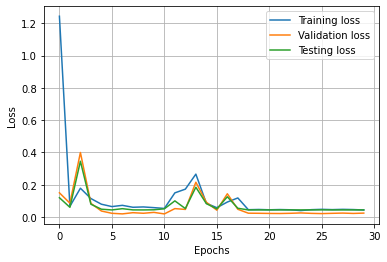

In [ ]:
# Graphs Losses ZoD AS
plt.plot(train_losses_epoch, label='Training loss')
plt.plot(val_losses_epoch, label='Validation loss')
plt.plot(test_losses_epoch, label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()